# Qcodes example with Rohde Schwarz RTO 1000 series Oscilloscope

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import qcodes as qc

from qcodes.instrument_drivers.rohde_schwarz.RTO1000 import RTO1000

In [2]:
rto = RTO1000('rto', 'TCPIP0::172.20.3.86::inst0::INSTR')

Connected to: Rohde&Schwarz RTO (serial:1316.1000k44/400363, firmware:3.70.1.0) in 0.23s


In [3]:
# Before we do anything, let's make sure that the instrument is in a clean state
#
# WARNING: This resets the instrument. Only execute this cell if you are sure about it!

rto.reset()

In [4]:
# The display should be set to 'remote' for better performance regarding data acquisition
# Most of the time, however, we'd like to look at the oscilloscope to see data
# and therefore set it to 'view'

rto.display('view')

In [5]:
# To get an overview of all instrument settings, print_readable_sanpshot is great
rto.print_readable_snapshot(update=True)

rto:
	parameter                value
--------------------------------------------------------------------------------
IDN                       :	{'firmware': '3.70.1.0', 'serial': '1316.1000k44/...
acquisition_sample_rate   :	1e+10 (Sa/s)
completed_acquisitions    :	270421 
dataformat                :	ASC,0 
display                   :	view 
high_definition_bandwidth :	1e+06 (Hz)
high_definition_state     :	OFF 
num_acquisitions          :	1 
run_mode                  :	RUN CONT 
sampling_rate             :	10000000000 (Sa/s)
timebase_position         :	0 (s)
timebase_range            :	1e-07 (s)
timebase_scale            :	1e-08 (s/div)
timeout                   :	5 (s)
trigger_display           :	OFF 
trigger_edge_slope        :	POS 
trigger_level             :	0 
trigger_source            :	CH1 
trigger_type              :	EDGE 
rto_channel3:
	parameter  value
--------------------------------------------------------------------------------
arithmetics :	OFF 
bandwidth   :	FULL 
cou

## A signal to record

For this tutorial, we record a **100 kHz sine wave** with a peak-to-peak amplitude of **100 mV** and an offset of **10 mV**.


## Input settings

Our waveform generator outputs 50 Ohm, so we better set the input coupling to DC 50 Ohm as well.
And turn on channel 1.

In [6]:
rto.ch1.coupling('DC')  # 'DC' means DC 50 Ohm, 'DCLimit' means DC 1 MOhm, 'AC' means AC 1 MOhm.
rto.ch1.state('ON')

## Triggering

Let us set up an edge trigger on channel 1 with a trigger level of 25 mV.

In [7]:
rto.trigger_source('CH1')
rto.trigger_type('EDGE')
rto.trigger_edge_slope('NEG')
rto.trigger_level(0.025)


## Acquisition pt. 1 (running continuously)

The oscilloscope can run continuously or acquire a fixed number of times (or of course not run at all).

In [8]:
rto.run_cont() # run continuously

## Horizontal settings

We want to see one period of the sine.

In [9]:
rto.timebase_range(1/100e3)
rto.timebase_position(5e-6)

## Vertical settings

We of course want the sine wave to fully occupy the oscilloscope screen.

In [10]:
# This is EXACTLY matching the waveform...
rto.ch1.range(0.1)
rto.ch1.offset(0)

In [11]:
#... but we increase it a bit due to noise
rto.ch1.range(0.11)

## Acquisition pt. 2 (averaging)

To average on the scope, you must activate the averaging arithmetics for
the relevant channel.

The averaging takes place irrespective of run mode. Here, we perform 1000 averages and then stop the acquisition by acquiring NxSINGLE shots.

If you average in continuous acquisition mode, you get a running average of the latest `num_acquisition` scope shots.

In [12]:
# Let's do 1000 averages of our sine wave

rto.num_acquisitions(1000)
rto.ch1.arithmetics('AVERAGE')  # other options: 'ENVELOPE' and 'OFF'
rto.run_single()  # and perform a single run. 

In [13]:
# To avoid running average effects, we reset the aqcuisition to "normal" mode
rto.num_acquisitions(1)
rto.ch1.arithmetics('OFF')
rto.run_cont()

## Reading out the trace - RUN CONT

In [14]:
# Before making a serious recording, consider whether you want 8 bit or 16 bit resolution
# This option may not be available on all scopes

rto.high_definition_state('ON')  # 'ON' -> 16 bit, 'OFF' -> 8 bit

In [15]:
##########################
# A NOTE ABOUT BANDWIDTH #
##########################

# In non-high definition state, each channel has its own bandwidth, that may either be
# 'FULL', 'B800', 'B200', or 'B20', where the numbers correspond to a bandwidth limit
# in MHz. In high defition mode, a global bandwidth limit is used.
rto.high_definition_bandwidth(1e9)

In [16]:
# Next, the trace must be prepared. This ensures that all settings are correct
rto.ch1.trace.prepare_trace()

DataSet:
   location = 'data/2017-12-14/#007_{name}_10-09-48'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (100000,)
acquired at 2017-12-14 10:09:49


<IPython.core.display.Javascript object>


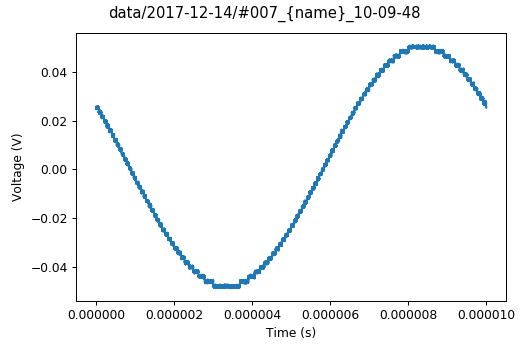

In [17]:
# Now make a measurement of the trace and display it
data_hd = qc.Measure(rto.ch1.trace).run()
plot = qc.MatPlot(data_hd.arrays['trace'])

DataSet:
   location = 'data/2017-12-14/#008_{name}_10-09-51'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (100000,)
acquired at 2017-12-14 10:09:52


<IPython.core.display.Javascript object>


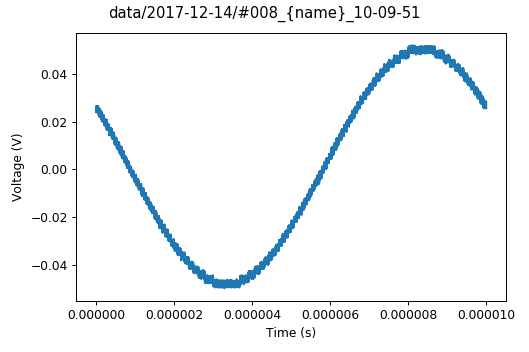

In [18]:
# Compare this to the 8 bit version:
rto.high_definition_state('OFF')
rto.ch1.trace.prepare_trace()
data_ld = qc.Measure(rto.ch1.trace).run()
plot = qc.MatPlot(data_ld.arrays['trace'])

## Reading out the trace - RUN Nx SINGLE

Oftentimes it is desirable to read out an averaged trace.
The driver makes sure that the acqusition has completed before asking for the trace.

For this example, we apply white noise with a **100 mV** peak-to-peak amplitude and no offset.

In [6]:
# to see averaging effects, we make the time base long
rto.timebase_range(0.1)

In [7]:
rto.ch1.trace.prepare_trace()

In [14]:
rto.num_acquisitions(10)
rto.ch1.arithmetics('AVERAGE')  # other options: 'ENVELOPE' and 'OFF'
rto.run_single()  # and perform a single run. NOTE: YOU MUST CALL THIS AS THE LAST THING BEFORE GETTING THE TRACE!!!

DataSet:
   location = 'data/2017-12-14/#011_{name}_10-43-29'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (1000000,)
acquired at 2017-12-14 10:43:50


<IPython.core.display.Javascript object>


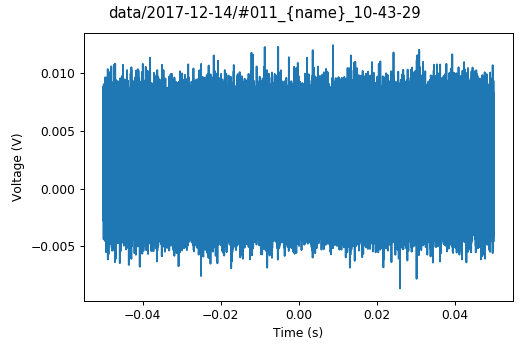

In [15]:
data_avgd = qc.Measure(rto.ch1.trace).run()
plot = qc.MatPlot(data_avgd.arrays['trace'])

DataSet:
   location = 'data/2017-12-14/#012_{name}_10-45-40'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (1000000,)
acquired at 2017-12-14 10:46:46


<IPython.core.display.Javascript object>


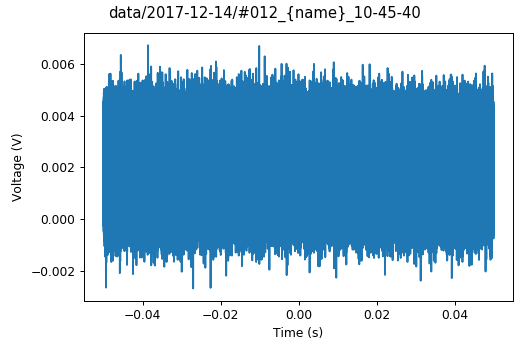

In [16]:
# We can see the averaging effect by increasing the number of averages

rto.num_acquisitions(500)
rto.ch1.arithmetics('AVERAGE')  # other options: 'ENVELOPE' and 'OFF'
rto.run_single()  # and perform a single run. NOTE: YOU MUST CALL THIS AS THE LAST THING BEFORE GETTING THE TRACE!!!
data_avgd = qc.Measure(rto.ch1.trace).run()
plot = qc.MatPlot(data_avgd.arrays['trace'])